**Step 1.** Import necessary libraries

In [7]:
import os

from VectorNet import config
from VectorNet.data_processor import DataProcessor
from VectorNet.common_utils import (
    get_scenario_map,
    get_filter_parameters
)

from nuplan.planning.scenario_builder.nuplan_db.nuplan_scenario_utils import ScenarioMapping
from nuplan.planning.scenario_builder.scenario_filter import ScenarioFilter
from nuplan.planning.scenario_builder.nuplan_db.nuplan_scenario_builder import NuPlanScenarioBuilder
from nuplan.planning.utils.multithreading.worker_parallel import SingleMachineParallelExecutor

**Step 2** Construct a `data_processor` class

In [10]:
# nuplan arguments
scenarios_per_type = 1000
total_scenarios = None
shuffle_scenarios = False

sensor_root = None
db_files = None

# create folder for processed data
os.makedirs(config.SAVE_PATH, exist_ok=True)

# get scenarios
scenario_mapping = ScenarioMapping(
    scenario_map=get_scenario_map(), 
    subsample_ratio_override=0.5
)

builder = NuPlanScenarioBuilder(
    config.DATA_PATH, 
    config.MAP_PATH, 
    sensor_root, 
    db_files, 
    config.MAP_VERSION, 
    scenario_mapping=scenario_mapping
)

# scenarios for training
scenario_filter = ScenarioFilter(
    *get_filter_parameters(
        scenarios_per_type, 
        total_scenarios, 
        shuffle_scenarios
    )
)

# enable parallel process
worker = SingleMachineParallelExecutor(use_process_pool=True)

# get scenarios
scenarios = builder.get_scenarios(scenario_filter, worker)

Do data processing

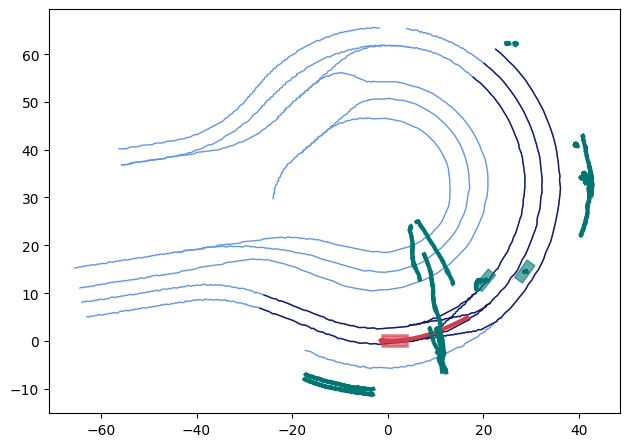

In [19]:
# pick a scenario
scenario = scenarios[8]

# do processing
data_processor = DataProcessor(scenario)
data, features = data_processor.process(debug=True)

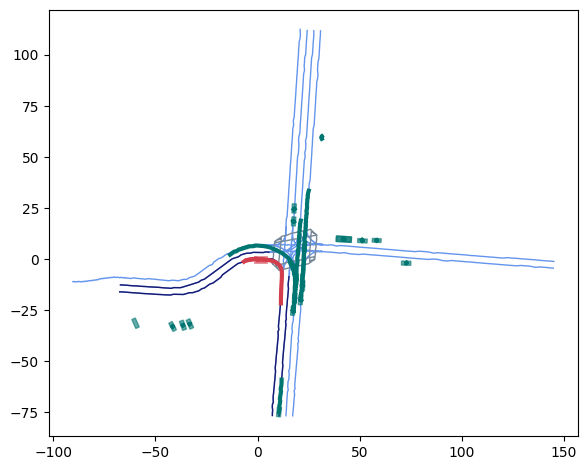

In [4]:
import os
from typing import List, Dict, Any
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from torch_geometric.data import InMemoryDataset
from torch_geometric.data import Data, DataLoader
import torch
from utils.feature_utils import compute_feature_for_one_seq, encoding_features, save_features
from utils.config import DATA_DIR, LANE_RADIUS, OBJ_RADIUS, OBS_LEN, INTERMEDIATE_DATA_DIR
from tqdm import tqdm

def get_fc_edge_index(num_nodes, start=0):
    """
    生成全连接图的边索引.

    Args:
        num_nodes: 图中节点的数量.
        start: 节点编号的起始值.

    Returns:
        tensor(2, num_edges): 边索引,表示图中所有的边.
        int: 下一个图的起始节点编号.
    """
    to_ = np.arange(num_nodes, dtype=np.int64)
    edge_index = np.empty((2, 0))
    for i in range(num_nodes):
        from_ = np.ones(num_nodes, dtype=np.int64) * i
        edge_index = np.hstack((edge_index, np.vstack((np.hstack([from_[:i], from_[i+1:]]), 
                                                        np.hstack([to_[:i], to_[i+1:]])))))
    edge_index = edge_index + start

    return edge_index.astype(np.int64), num_nodes + start


class GraphData(Data):
    """
    覆盖父类的 `__inc__` 方法,定义图数据中一些索引的递增方式,
    例如边索引 `edge_index` 根据节点特征 `x` 的数量递增.
    """

    def __inc__(self, key, value):
        if key == 'edge_index':
            return self.x.size(0)
        elif key == 'cluster':
            return int(self.cluster.max().item()) + 1
        else:
            return 0


class GraphDataset(InMemoryDataset):
    """
    基于 PyTorch Geometric 的图数据集对象,类似于 `torchvision` 中的数据集对象.
    """

    def __init__(self, root, transform=None, pre_transform=None):
        super(GraphDataset, self).__init__(root, transform, pre_transform)
        self.data, self.slices = torch.load(self.processed_paths[0])

    @property
    def raw_file_names(self):
        return []

    @property
    def processed_file_names(self):
        return ['dataset.pt']

    def download(self):
        pass

    def process(self):
        """
        数据处理逻辑,将原始数据转换为图数据.
        """

        def get_data_path_ls(dir_):
            return [os.path.join(dir_, data_path) for data_path in os.listdir(dir_)]
        
        # 确保结果的确定性,对数据路径列表排序
        data_path_ls = sorted(get_data_path_ls(self.root))

        valid_len_ls = []
        data_ls = []
        for data_p in tqdm(data_path_ls):
            if not data_p.endswith('pkl'):
                continue
            x_ls = []
            y = None
            cluster = None
            edge_index_ls = []
            data = pd.read_pickle(data_p)
            
            # 从 DataFrame 中提取数据
            # MODIFIED: 假设 `POLYLINE_FEATURES`, `TARJ_LEN`, `GT`, `TRAJ_ID_TO_MASK`, `LANE_ID_TO_MASK` 是数据中的字段
            all_in_features = data['POLYLINE_FEATURES'].values[0]  
            add_len = data['TARJ_LEN'].values[0]
            cluster = all_in_features[:, -1].reshape(-1).astype(np.int32)
            valid_len_ls.append(cluster.max())
            y = data['GT'].values[0].reshape(-1).astype(np.float32)

            traj_mask, lane_mask = data["TRAJ_ID_TO_MASK"].values[0], data['LANE_ID_TO_MASK'].values[0]
            agent_id = 0
            edge_index_start = 0
            
            # 检查 agent_id 是否正确
            assert all_in_features[agent_id][-1] == 0, f"agent id 错误. id {agent_id}: 类型 {all_in_features[agent_id][4]}"

            # 为每个轨迹构建全连接图
            for id_, mask_ in traj_mask.items():
                data_ = all_in_features[mask_[0]:mask_[1]]
                edge_index_, edge_index_start = get_fc_edge_index(data_.shape[0], start=edge_index_start)
                x_ls.append(data_)
                edge_index_ls.append(edge_index_)

            # 为每条车道构建全连接图  
            for id_, mask_ in lane_mask.items():
                data_ = all_in_features[mask_[0]+add_len: mask_[1]+add_len]
                edge_index_, edge_index_start = get_fc_edge_index(data_.shape[0], edge_index_start)
                x_ls.append(data_)
                edge_index_ls.append(edge_index_)

            edge_index = np.hstack(edge_index_ls)
            x = np.vstack(x_ls)
            data_ls.append([x, y, cluster, edge_index])

        # [x, y, cluster, edge_index, valid_len]
        g_ls = []
        
        # 对所有图的特征进行 padding, 使其具有相同的时间步长
        max_valid_len = np.max(valid_len_ls)  # MODIFIED: 重命名 `padd_to_index` 为更有意义的 `max_valid_len`
        feature_len = data_ls[0][0].shape[1]
        
        for ind, tup in enumerate(data_ls):
            # padding
            tup[0] = np.vstack([tup[0], np.zeros((max_valid_len - tup[-2].max(), feature_len), dtype=tup[0].dtype)])
            
            # 更新 cluster, 为 padding 后新增的节点赋予唯一 id
            tup[-2] = np.hstack([tup[2], np.arange(tup[-2].max()+1, max_valid_len+1)])  
            
            g_data = GraphData(
                x=torch.from_numpy(tup[0]),
                y=torch.from_numpy(tup[1]),
                cluster=torch.from_numpy(tup[2]),
                edge_index=torch.from_numpy(tup[3]),
                valid_len=torch.tensor([valid_len_ls[ind]]),
                time_step_len=torch.tensor([max_valid_len + 1])  # MODIFIED: 更正为 `max_valid_len + 1`
            )
            g_ls.append(g_data)
        data, slices = self.collate(g_ls)
        torch.save((data, slices), self.processed_paths[0])
